# Imports

In [1]:
import pysweep
import pysweep.databackends.debug
import pysweep.databackends.list_backend
import pysweep.databackends.qcodes
import pysweep.core.measurementfunctions
from pysweep.core.sweepobject import SweepObject
from pysweep.core.measurementfunctions import MakeMeasurementFunction
from pysweep.databackends.base import DataParameterFixedAxis
from pysweep.databackends.base import DataParameter
import pysweep.convenience as conv

from pytopo.awg_sequencing import awg_tools
from pytopo.rf.alazar import acquisition_controllers
from pytopo.rf.alazar import acquisition_tools
from pytopo.rf.alazar import softsweep as ss
from pytopo.rf.sources import HeterodyneSource


import qcodes as qc
from qcodes.dataset.measurements import Measurement
import qcodes.dataset.plotting

from cqed.utils.datahandling import create_local_dbase_in
import cqed.custom_pysweep_functions.vna as cvna
import cqed.custom_pysweep_functions.magnet as cmgnt

import numpy as np
import matplotlib.pyplot as plt

# Set up station and QCoDeS database

## Set up measurement station

### K1

In [ ]:
station = qc.Station(config_file=r'D:\OneDrive\Setups\LK1\LK1_code\code\cqed\station_init\LK1.station.yaml')

### K2

In [2]:
station = qc.Station(config_file=r'D:\OneDrive\Setups\LK2\LK2_code\code\cqed\station_init\LK2.station.yaml')

## Set up instruments

In [3]:
mgnt = station.load_instrument('mgnt', field_limits=cmgnt.field_limit)
print('current X-field:', station.mgnt.x_measured(), 'T')
print('current Y-field:',station.mgnt.y_measured(), 'T')
print('current Z-field:',station.mgnt.z_measured(), 'T')

Connected to: OXFORD INSTRUMENTS MERCURY IPS (serial:123550029, firmware:2.5.09.000) in 0.22s
current X-field: 0.0 T
current Y-field: 0.0 T
current Z-field: -0.0 T


In [ ]:
ivvi = station.load_ivvi()
ivvi.print_readable_snapshot()

In [4]:
qubsrc = station.load_qubsrc()

RF = station.load_RF()
RF.ref_osc_source('EXT')
RF.ref_osc_external_freq('10MHz')
RF.ref_LO_out('LO')

LO = station.load_LO()
LO.ref_osc_source('INT')
LO.ref_osc_output_freq('10MHz')

TWPA = station.load_TWPA()
TWPA.ref_osc_source('EXT')
TWPA.ref_osc_external_freq('10MHz')

hetsrc = HeterodyneSource('hetsrc', RF=RF, LO=LO)
station.add_component(hetsrc)
hetsrc.IF(25e6)

Connected to: Agilent Technologies E8267C (serial:US42340172, firmware:C.03.85) in 0.05s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/111578, firmware:4.2.76.0-4.30.046.195) in 0.03s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110432, firmware:3.1.19.15-3.50.124.67) in 0.03s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110868, firmware:3.1.19.26-3.50.124.73) in 0.03s


In [5]:
awg = station.load_awg()
awg.ref_source('EXT')

Connected to: TEKTRONIX AWG5014C (serial:B050346, firmware:SCPI:99.0 FW:4.6.0.7) in 0.06s


In [6]:
alazar = station.load_alazar()
acquisition_tools.simple_alazar_setup_ext_trigger(256, 1, 1)

C:\Users\LocalAdmin\.conda\envs\qcodes\lib\site-packages\qcodes\instrument_drivers\AlazarTech\ATS.py:335: UserWarning: Using Internal clock but parameter external_sample_rate is set.This will have no effect and is ignored
  warnings.warn("Using Internal clock but parameter external_sample_rate is set."


In [7]:
# controller for 'simple' post-acquisition demod
post_iq_acq = acquisition_controllers.PostIQCtl('post_iq_acq', 'alazar', allocate_samples=5e8)
station.add_component(post_iq_acq)
post_iq_acq.demod_frq(hetsrc.IF())
post_iq_acq.reference_channel(1)

# controller that can step frequencies during acquisition.
softsweep_ctl = ss.SoftSweepCtl('softsweep_ctl', 'alazar', allocate_samples=5e8)
station.add_component(softsweep_ctl)
softsweep_ctl.demod_frq(hetsrc.IF())
softsweep_ctl.reference_channel(1)

Allocating 500000000 elements (2000.0 MB, dtype: <class 'numpy.int32'>)
Allocating 500000000 elements (2000.0 MB, dtype: <class 'numpy.int32'>)


In [8]:
from pytopo.rf.alazar.awg_sequences import TriggerSequence

TriggerSequence.chan_map = {
    1 : ['pulse', 'ats_trigger', 'ro_trigger'],
}
TriggerSequence.chan_settings = {
    1 : {
        'marker_hi' : [1.5, 1.5],
        'marker_lo' : [-0.3, -0.3],
        },
    2 : {
        'marker_hi' : [1.5, 1.5],
        'marker_lo' : [-0.3, -0.3],
        },
}

In [12]:
fvals = np.arange(5, 6.0, 1e-3) * 1e6
ss.setup_triggered_softsweep(softsweep_ctl, station.hetsrc.frequency, fvals, 20e-3,
                             time_bin=0.5e-3, setup_awg=True, verbose=True, post_integration_delay=10e-6)

Setup capture: 15974.4 MB total
 * Buffers: 40000 (0.39936 MB/buffer) | (Allocated buffers: 40 = 15.9744 MB)
 * Records: 1 (0.39936 MB/record)
 * Samples: 49920 (= 499.2 us)
 * Channels: 2


In [13]:
fvals = np.arange(5, 6.0, 2e-3) * 1e9
softsweep_ctl.next_point_trigger_func = lambda: awg_tools.trigger_awg_when_ready(station.awg)
softsweep_ctl.settling_time = 0.01

ds = ss.measure_triggered_softsweep(
    softsweep_ctl, station.hetsrc.frequency, fvals, integration_time=20e-3, channel=0
)

Starting experimental run with id: 20. 
Setup capture: 7987.2 MB total
 * Buffers: 20000 (0.39936 MB/buffer) | (Allocated buffers: 40 = 15.9744 MB)
 * Records: 1 (0.39936 MB/record)
 * Samples: 49920 (= 499.2 us)
 * Channels: 2


In [16]:
data = np.squeeze(softsweep_ctl.acquisition())[..., 0]

In [18]:
data = qc.load_by_id(20) 

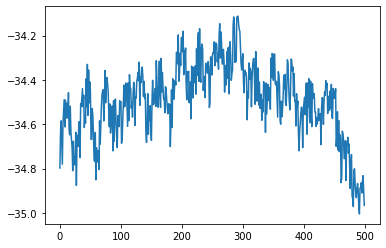

In [25]:
plt.plot(20*np.log10(data.get_data('amplitude')[0][0]))

([<matplotlib.axes._subplots.AxesSubplot at 0x23a46778148>,
 [None, None])

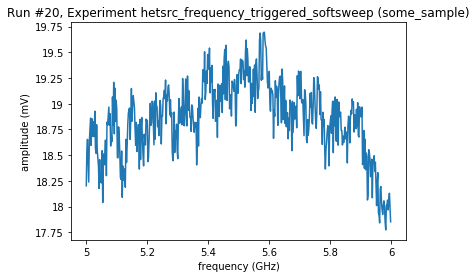

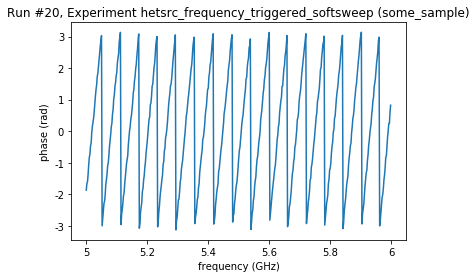

In [14]:
qcodes.dataset.plotting.plot_by_id(20)

In [44]:
class manual_ac(qcodes.instrument_drivers.AlazarTech.ATS.AcquisitionController):
    def __init__(self, name, alazar_name, **kwargs):
        self.acquisitionkwargs = {}
        super().__init__(name, alazar_name, **kwargs)
        self.buffer = None
        
    def pre_start_capture(self):
        self.buffer = None
        
    def pre_acquire(self):
        pass
    
    def handle_buffer(self, buffer, buffer_number=None):
        self.buffer = buffer.copy()
        
    def post_acquire(self):
        return self.buffer
    
    def do_acquisition(self):
        """
        this method performs an acquisition, which is the get_cmd for the
        acquisiion parameter of this instrument
        :return:
        """
        value = self._get_alazar().acquire(acquisition_controller=self,
                                           **self.acquisitionkwargs)
        return value

In [45]:
mac = manual_ac('mac', 'alazar')

In [46]:
mac.acquisitionkwargs = dict(samples_per_record=9600, records_per_buffer=1, buffers_per_acquisition=1, channel_selection='A', mode='NPT')

In [70]:
r = mac.do_acquisition()

In [71]:
alazar.signal_to_volt(1, r)

array([-0.00352941, -0.01294118, -0.02078431, ...,  0.02      ,
        0.01137255,  0.00431373])

In [74]:
alazar.channel_range1()

0.1

(0, 100)

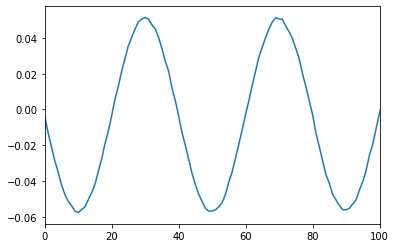

In [73]:
plt.plot(alazar.signal_to_volt(1, r))
plt.xlim(0,100)

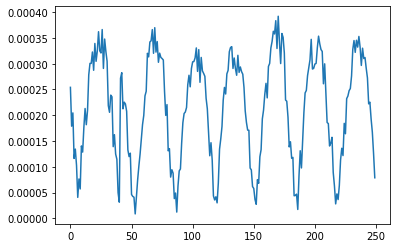

In [26]:
plt.plot(np.abs(data0))

In [59]:
ss.setup_single_averaged_IQpoint?

Object `ss.setup_single_averaged_IQpoint` not found.


## Pass measurement station to pysweep 


### To be removed after merging of pysweep pull request #19

In [ ]:
pysweep.STATION = station

## Name and initialize database

In [11]:
# To place the database in D:/Data/MyExperiment/ use:
folder = 'AlazarTesting'

# To place the database in a more nested folder structure, e.g. D:/Data/MyExperiment/TestSample/FirstMeasurements/, use:
# folder = 'MyExperiment/TestSample/FirstMeasurements'

# Name your database
database_name = '2020_02-13_Run1'

create_local_dbase_in(folder_name=folder, db_name='%s.db' %(database_name))

qc.config['core']['db_location']

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]
Upgrading database; v1 -> v2: 100%|███████████████████████████████████████████████| 1/1 [00:00<00:00, 499.98it/s]
Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]
Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]
Upgrading database; v4 -> v5: 100%|███████████████████████████████████████████████| 1/1 [00:00<00:00, 500.04it/s]
Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]
Upgrading database; v7 -> v8: 100%|███████████████████████████████████████████████| 1/1 [00:00<00:00, 333.41it/s]


WindowsPath('D:/Data/AlazarTesting/2020_02-13_Run1.db')

# Define pysweep functions

In [ ]:
# Function called before beginning of measurement loop.
# This is a good place to define the VNA sweep parameters. Can also be made a function with changable parameters.

def init_measurement(d):
    # This block only to always set the electrical delay before each measurement.
    # Large frequency range gives a more accurate automatic setting.
    station.vna.S21.start(4e9)
    station.vna.S21.stop(8e9)
    station.vna.S21.set_electrical_delay_auto()
    # End of autodelay set
    
    station.vna.rf_on()
    station.vna.S21.start(4e9)
    station.vna.S21.stop(5e9)
    station.vna.S21.npts(1001)
    
    station.vna.S21.power(-20)
    station.vna.S21.bandwidth(1e3)
    station.vna.S21.avg(10)
    
    print('Starting measurement.')
    
# Function called after the end of the measurement.
def end_measurement(d):
    print('Measurement finished.')

# Single VNA trace

This just records a single VNA trace with the VNA parameters currently set or set (if specified) in the init_measurement function.

In [ ]:
# Give your sample a meaningful name.
sample_name = 'sample1'

exp = qc.load_or_create_experiment(experiment_name='single_VNA_trace', sample_name=sample_name)
meas = Measurement(exp, station)

result = pysweep.sweep(init_measurement, end_measurement, cvna.return_vna_trace,
                 databackend = pysweep.databackends.qcodes.DataBackend(meas))

For plotting of the generated dataset in the notebook directly

In [ ]:
qc.dataset.plotting.plot_dataset(result.datasaver.dataset)

# Power sweep

In [ ]:
# Give your sample a meaningful name.
sample_name = 'sample1'

exp = qc.load_or_create_experiment(experiment_name='VNA_vs_pwr', sample_name=sample_name)
meas = Measurement(exp, station)

result = pysweep.sweep(init_measurement, end_measurement, cvna.return_vna_trace, 
                  pysweep.sweep_object(station.vna.S21.power, np.arange(-50, -15, 5)),
                  databackend = pysweep.databackends.qcodes.DataBackend(meas))

# Gate sweep

In [ ]:
# Give your sample a meaningful name.
sample_name = 'sample1'

exp = qc.load_or_create_experiment(experiment_name='VNA_vs_gate', sample_name=sample_name)
meas = Measurement(exp, station)

result = pysweep.sweep(init_measurement, end_measurement, cvna.return_vna_trace, 
                  pysweep.sweep_object(station.ivvi.dac1, np.arange(0, 1010, 10)),
                  databackend = pysweep.databackends.qcodes.DataBackend(meas))

# Magnetic field sweep

## Setting of x, y, z magnetic fields

In [ ]:
station.mgnt.field_ramp_rate(FieldVector(x=3e-3, y=3e-3, z=3e-3))

In [ ]:
# Get current field strength of x, y, and z component.
print(station.mgnt.x_measured())
print(station.mgnt.y_measured())
print(station.mgnt.z_measured())

In [ ]:
# Set all target field components to some (reasonable) value and ramp magnetic field.
# After ramping, check field strength
station.mgnt.x_target(0.0e-3)
station.mgnt.y_target(0.0e-3)
station.mgnt.z_target(0.1e-3)

station.mgnt.ramp(mode='safe')

print(station.mgnt.r_measured())
print(station.mgnt.phi_measured())
print(station.mgnt.theta_measured())

## The following functions are under testing, ask Lukas G./S.

The sweep functions below explicitly calculate x, y, and z components from the spherical component input. This is done for greater control of the actual sweeping direction of the magnet

For the actual measurement, we make use of the '+' functionality of pysweep, to record the measured magnetic field components along with the desired setpoints.

### Phi sweep

In [ ]:
# Give your sample a meaningful name.
sample_name = 'sample1'

exp = qc.load_or_create_experiment(experiment_name='VNA_vs_mgnt-phi', sample_name=sample_name)
meas = Measurement(exp, station)

result = pysweep.sweep(init_measurement, end_measurement, cmgnt.measure_magnet_components + cvna.return_vna_trace, 
                  cmgnt.sweep_phi(r = 3.0e-3, theta = 90, points = np.arange(0, 360, 5)),
                  databackend = pysweep.databackends.qcodes.DataBackend(meas))

### Theta sweep

In [ ]:
# Give your sample a meaningful name.
sample_name = 'sample1'

exp = qc.load_or_create_experiment(experiment_name='VNA_vs_mgnt-theta', sample_name=sample_name)
meas = Measurement(exp, station)

result = pysweep.sweep(init_measurement, end_measurement, cmgnt.measure_magnet_orientation + cvna.return_vna_trace, 
                  cmgnt.sweep_theta(r = 3.0e-3, phi = 90, points = np.arange(0, 180, 5)),
                  databackend = pysweep.databackends.qcodes.DataBackend(meas))

### r sweep

In [ ]:
# Give your sample a meaningful name.
sample_name = 'sample1'

exp = qc.load_or_create_experiment(experiment_name='VNA_vs_mgnt-r', sample_name=sample_name)
meas = Measurement(exp, station)

result = pysweep.sweep(init_measurement, end_measurement, cmgnt.measure_magnet_orientation + cvna.return_vna_trace, 
                  cmgnt.sweep_r(phi = 90, theta = 0, points = np.arange(0, 20e-3, 2e-3)),
                  databackend = pysweep.databackends.qcodes.DataBackend(meas))